In [ ]:
import pandas as pd
import plotly.express as px
data = pd.read_parquet("../data/multi_event.parquet", engine="fastparquet")

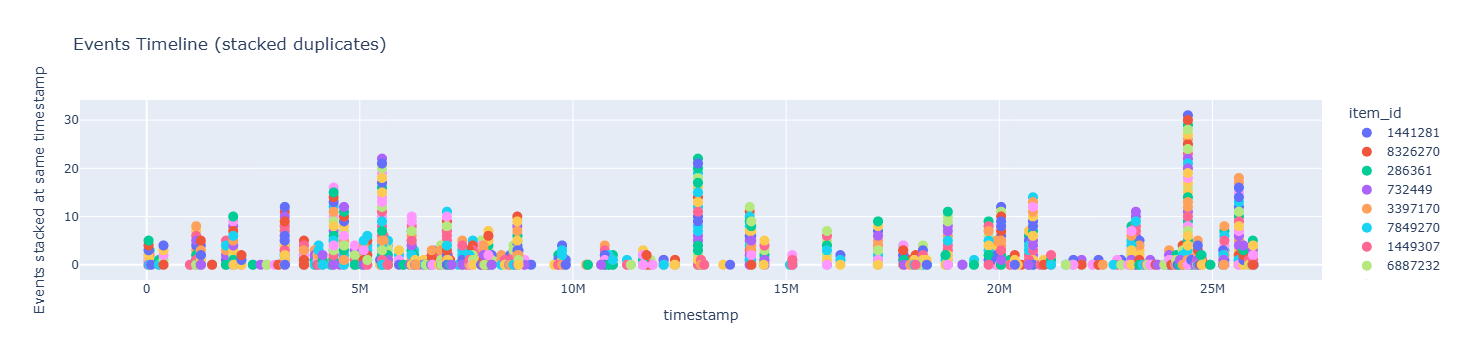

In [6]:
import plotly.express as px
import pandas as pd

df = data[(data["uid"] == 100) & (data["event_type"] == "listen")].sort_values("timestamp")
# df = data[(data["uid"] == 997500) & (data["event_type"] == "listen")].sort_values("timestamp")#[3021:3100]


df["count_sec"] = df["track_length_seconds"]*df["played_ratio_pct"]*0.01

df["stack_level"] = df.groupby("timestamp").cumcount()

fig = px.scatter(
    df,
    x="timestamp",
    y="stack_level",
    color="item_id",

    hover_data=["event_type", "timestamp", "count_sec"],
    
    title="Events Timeline (stacked duplicates)"
)


fig.update_traces(marker=dict(size=10))
fig.update_yaxes(title="Events stacked at same timestamp", showgrid=True)
fig.show()


In [7]:
data["item_id"].value_counts()

5862961    42960
6901374    41767
3542184    41088
9378983    39824
5635052    39621
           ...  
2340893        1
9248176        1
4024161        1
5050081        1
8392535        1
Name: item_id, Length: 934057, dtype: int64

In [ ]:
import plotly.express as px
import pandas as pd

df = data[(data["item_id"] == 5862961) & (data["event_type"] == "listen")].sort_values("timestamp")
# df = data[(data["uid"] == 997500) & (data["event_type"] == "listen")].sort_values("timestamp")#[3021:3100]


df["count_sec"] = df["track_length_seconds"]*df["played_ratio_pct"]*0.01

df["stack_level"] = df.groupby("timestamp").cumcount()

fig = px.scatter(
    df,
    x="timestamp",
    y="stack_level",
    color="item_id",

    hover_data=["event_type", "timestamp", "count_sec"],
    
    title="Events Timeline (stacked duplicates)"
)


fig.update_traces(marker=dict(size=10))
fig.update_yaxes(title="Events stacked at same timestamp", showgrid=True)
fig.show()


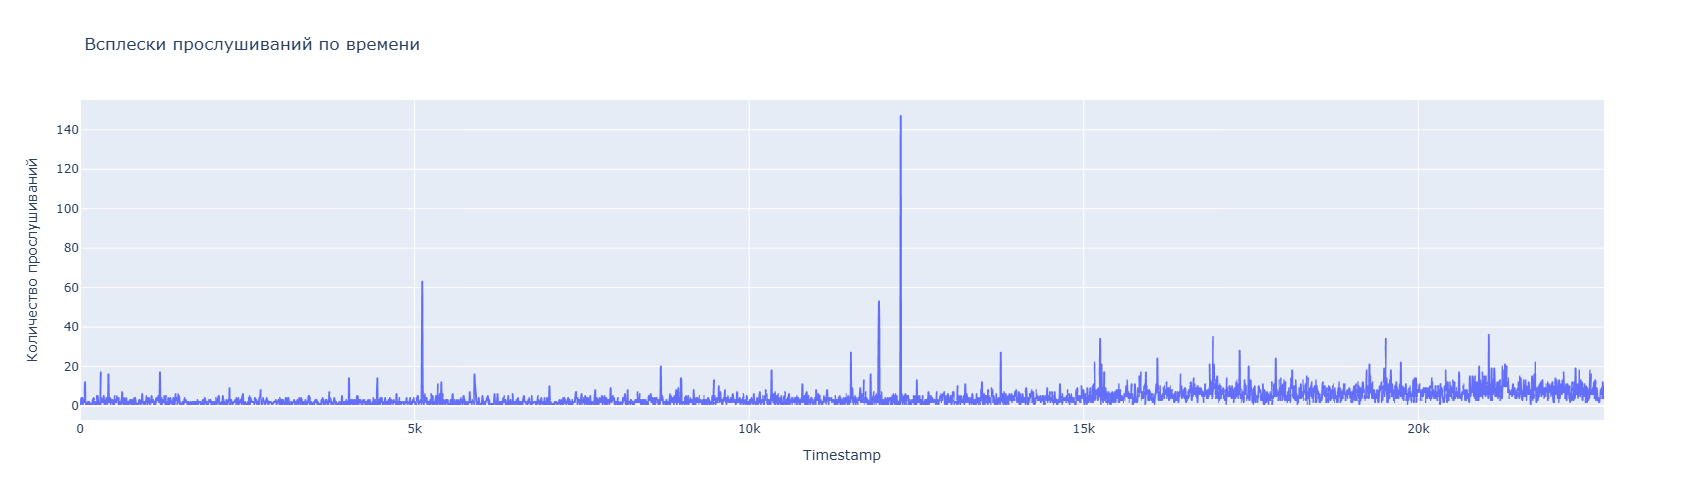

In [18]:
season_pattern = data[(data["item_id"] == 5862961)] 
    
season_pattern = season_pattern[:4000]
import plotly.express as px

fig = px.line(
    season_pattern.reset_index(),
    x="timestamp",
    y=0,
    title="Всплески прослушиваний по времени",
    labels={"timestamp": "Timestamp", "0": "Количество прослушиваний"}
)

fig.update_layout(
    width=1200,
    height=500
)

fig.show()

In [1]:
import plotly.express as px
import pandas as pd


# season_pattern = data[data["item_id"] == 5862961].copy()
season_pattern = pd.read_parquet("../data/multi_event.parquet", engine="fastparquet")

# timestamp (шаг 5 секунд) → datetime
season_pattern["ts"] = pd.to_datetime(season_pattern["timestamp"] * 5, unit="s")

# ✔ Месяц (число)
season_pattern["month"] = season_pattern["ts"].dt.month

# ✔ День недели (0 = Пн)
season_pattern["day_of_week"] = season_pattern["ts"].dt.dayofweek

# ✔ Час суток
season_pattern["hour"] = season_pattern["ts"].dt.hour

# ✔ Названия месяцев
month_map = {
    1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель",
    5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
    9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
}

# ✔ Названия дней недели
weekday_map = {
    0: "Понедельник",
    1: "Вторник",
    2: "Среда",
    3: "Четверг",
    4: "Пятница",
    5: "Суббота",
    6: "Воскресенье"
}




In [2]:
season_pattern = season_pattern[["item_id", "hour", "month", "day_of_week"]] 
season_pattern

,item_id,hour,month,day_of_week
0,8326270,6,1,5
1,1441281,6,1,5
2,286361,7,1,5
3,732449,7,1,5
4,3397170,8,1,5
...,...,...,...,...
47790444,3369589,9,2,0
47790445,8120372,9,2,0
47790446,1578810,10,2,0
47790447,3732104,10,2,0


In [14]:
import pandas as pd

# 24 часа
hour_features = (
    season_pattern.groupby(["item_id", "hour"]).size()
      .unstack(fill_value=0)
      .add_prefix("hour_")
)

# 7 дней недели
weekday_features = (
    season_pattern.groupby(["item_id", "day_of_week"]).size()
      .unstack(fill_value=0)
      .add_prefix("wd_")
)

# 12 месяцев
month_features = (
    season_pattern.groupby(["item_id", "month"]).size()
      .unstack(fill_value=0)
      .add_prefix("month_")
)


# Объединяем всё в единый датафрейм
item_features = (
    month_features
    # .join(weekday_features, how="outer")
    # .join(hour_features, how="outer")

    .fillna(0)
)

item_features.head()

month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
item_id,,,,,,,,,,,,
22,0,0,0,0,1,0,0,0,0,0,0,0
26,1,0,2,4,0,2,0,0,1,3,1,3
43,0,1,1,0,0,0,0,0,0,0,0,1
50,1,4,1,1,5,3,4,7,8,13,7,6
71,0,0,0,0,0,0,0,0,0,2,0,0


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(item_features)

In [16]:
from sklearn.cluster import KMeans

k = 7  # можно менять
model = KMeans(n_clusters=k, random_state=42)

item_clusters = model.fit_predict(X)

item_features["cluster"] = item_clusters

In [17]:
item_features["cluster"].value_counts()

1    903375
0     22761
5      5510
3      1751
2       517
4       121
6        22
Name: cluster, dtype: int64

In [8]:
len(item_features)

22612

934057

In [19]:
item_features[item_features["cluster"] == 1] #["hour"]

month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,cluster
item_id,,,,,,,,,,,,,
22,0,0,0,0,1,0,0,0,0,0,0,0,1
26,1,0,2,4,0,2,0,0,1,3,1,3,1
43,0,1,1,0,0,0,0,0,0,0,0,1,1
50,1,4,1,1,5,3,4,7,8,13,7,6,1
71,0,0,0,0,0,0,0,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9390576,0,0,0,0,0,0,0,0,0,0,0,1,1
9390581,0,1,0,0,1,0,0,0,0,0,0,0,1
9390585,1,1,0,0,0,0,0,0,3,0,0,1,1


In [23]:
month_cols = [f"month_{i}" for i in range(1, 13)]

item_features["most_popular_month"] = (
    item_features[month_cols].idxmax(axis=1)
)


item_features

month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,cluster,most_popular_month
item_id,,,,,,,,,,,,,,
22,0,0,0,0,1,0,0,0,0,0,0,0,1,month_5
26,1,0,2,4,0,2,0,0,1,3,1,3,1,month_4
43,0,1,1,0,0,0,0,0,0,0,0,1,1,month_2
50,1,4,1,1,5,3,4,7,8,13,7,6,1,month_10
71,0,0,0,0,0,0,0,0,0,2,0,0,1,month_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9390576,0,0,0,0,0,0,0,0,0,0,0,1,1,month_12
9390581,0,1,0,0,1,0,0,0,0,0,0,0,1,month_2
9390585,1,1,0,0,0,0,0,0,3,0,0,1,1,month_9


In [25]:
item_features["most_popular_month"]

item_id
22          month_5
26          month_4
43          month_2
50         month_10
71         month_10
             ...   
9390576    month_12
9390581     month_2
9390585     month_9
9390601     month_5
9390623     month_2
Name: most_popular_month, Length: 934057, dtype: object

In [2]:
import pandas as pd

data = pd.read_parquet("../data/multi_event.parquet", engine="fastparquet")



In [3]:
def train_test_split(data, test_size, train_size, gap_size = 30):
    
    
    
    HOUR_SECONDS = 60 * 60
    DAY_SECONDS = 24 * HOUR_SECONDS
    
    GAP_SIZE = HOUR_SECONDS // 2
    TEST_SIZE = test_size * DAY_SECONDS

    overall_days = (data["timestamp"].max() - data["timestamp"].min())//DAY_SECONDS
    
    data = data[data['timestamp'] > (overall_days-train_size) * DAY_SECONDS]
    
    LAST_TIMESTAMP = data["timestamp"].max()
    
    TEST_TIMESTAMP = LAST_TIMESTAMP - TEST_SIZE
    
    TRAIN_TIMESTAMP = TEST_TIMESTAMP - GAP_SIZE
    
    train_df = data[data['timestamp'] < TRAIN_TIMESTAMP]
    test_df = data[data['timestamp'] > TEST_TIMESTAMP]

    return train_df, test_df



In [50]:


# for uid  in data["uid"].unique():
#     df = data[(data["uid"] == uid) & (data["event_type"] == "listen")].sort_values("timestamp")
#     train_df, test_df = train_test_split(df, 1, 20, gap_size = 30)
#     listen_train = train_df["item_id"].value_counts().index.tolist()
#     listen_test = test_df["item_id"].unique()
#     new_listen = set(listen_test) - set(listen_train)


#     if len(listen_test)!=0:
#         print((len(listen_test)-len(new_listen))/len(listen_test))
#     else: 
#         print("not listen last time")
    

In [13]:
listen_test

array([3175251,  286361, 5368486, 5455911, 2655409,  239869, 7092180,
       2366618, 5204435, 9101773, 8670637, 6005659, 5331227, 5282985,
        176455, 9256068,  384146, 2621343, 6826591, 4704892, 5598042,
       5114754, 1299533, 7415847, 6870586, 4734787, 8276189, 7278584,
       1080439, 1098780, 7057545, 1708006, 4242742, 2297176, 8379325,
       2137173, 1464722, 9231462,  721863, 5080642, 4291482, 5621929,
       7434489, 4730233, 3032054, 8695195, 6996639, 6620083,  911737,
       6043575, 7498961, 7338725, 1118437, 3337591, 3642061, 8632822,
       9100965, 8326270, 8464496,  342165, 3526521, 2263048,  982903,
       5590855, 3535902, 8200811, 4099299, 4221787, 3633039, 3982388,
       6399268, 1730273,  410868, 4943655, 7371186], dtype=uint32)

In [15]:
listen_train

[6511826,
 2263048,
 3982388,
 982903,
 3526521,
 5590855,
 3535902,
 6996639,
 2655409,
 7434489]

In [21]:
listen_train = train_df["item_id"].value_counts()

0.55

In [51]:
df = data[(data["uid"] == 200) & (data["event_type"] == "listen")].sort_values("timestamp")
train_df, test_df = train_test_split(df, 1, 20, gap_size = 30)
listen_train = train_df["item_id"].unique()
print(train_df["item_id"].value_counts())
listen_test = test_df["item_id"].unique()
new_listen = set(listen_test) - set(listen_train)

8420846    5
6442869    4
7092285    4
8337489    4
5541190    4
          ..
3047889    1
2907756    1
6736868    1
7409200    1
7714273    1
Name: item_id, Length: 195, dtype: int64


In [45]:
new_listen = set(listen_test) - set(listen_train)
len(listen_test)

29

0.23684210526315788

In [54]:
df["is_organic"].value_counts()

1    354
Name: is_organic, dtype: int64